# Word Counts

Problem: okay counts are wrong

In [1]:
import pandas as pd
import sqlite3
import os
import numpy as np

from helpers.make_latex_table import create_latex_tables
from helpers.normalization import remove_punctuation, remove_punctuation_and_newlines, remove_capitalization
from helpers.statistical_tests import run_t_test_on_gender, compare_genders

db_path = "../../giicg.db"
if not os.path.exists(db_path):
    raise FileNotFoundError(f"Database file does not exist: {db_path}")

conn = sqlite3.connect(db_path)
prompts = pd.read_sql("SELECT ep.*, u.age, u.work_exp_years FROM expanded_prompts ep JOIN users u ON ep.user_id = u.user_id", conn)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Clean, filter and normalize

In [2]:
prompts = prompts[prompts['gender'].isin(['Man (cisgender)', 'Woman (cisgender)'])]

prompts = prompts.dropna(subset=['conversational'])
prompts = prompts[prompts['conversational'].str.strip() != '']
prompts = prompts.dropna(subset=['conversational'])

#prompts['conversational'] = prompts['conversational'].apply(remove_punctuation_and_newlines)
prompts['conversational'] = prompts['conversational'].apply(remove_capitalization)

## Combine per user

In [3]:
user_prompts = (
    prompts
    .fillna({'work_exp_years': 'None'})
    .groupby(['user_id', 'gender', 'age', 'work_exp_years'])['conversational']
    .apply(' '.join)
    .reset_index()    # Reset index to create a DataFrame
)
user_prompts['n_words'] = user_prompts['conversational'].apply(lambda x: len(x.split()))


## Helper functions and types

In [5]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import multipletests
from matplotlib import pyplot as plt
import seaborn as sns
from helpers.occurences import count_occurrences


def count(df, group_name, word_types, word_lists):
    for word_type, word_list in zip(word_types, word_lists):
        for word in word_list:
            df[word] = df['conversational'].apply(lambda x: (count_occurrences(x, word, True))/len(x.split()))
        df[word_type] = df[word_list].sum(axis=1)
    df[group_name] = df[word_types].sum(axis=1)
    return df

gender_palette = {'Woman (cisgender)': 'red', 'Man (cisgender)': 'blue'}
age_palette = {'19-25': 'red', '26-30': 'orange', '31-35': 'yellow', '36-40': 'green', '41-50': 'blue', '51-60': 'purple'}


def box_plot(df, id_vars, bar_variables, x_label, y_label, hue_variable, palette):
    melted = df.melt(
    id_vars=id_vars,
    value_vars=bar_variables,
    var_name=x_label,
    value_name=y_label
)

    plt.figure(figsize=(8,6))
    sns.boxplot(
        data=melted,
        x=x_label,
        y=y_label,
        hue=hue_variable,
        palette=palette,
        width=0.7
    )

    plt.title(f'Counts and Scores by {hue_variable}')
    plt.ylabel('Average Count/Score Rate (per word)')
    plt.xlabel('Score/Count')
    plt.legend(title=hue_variable)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


from helpers.statistical_tests_new import compare_groups
from statsmodels.stats.multitest import multipletests


def groupwise_comparison_with_correction(df, columns, one_sided=False, direction="greater"):
    stat_vals = []
    dfs = []
    p_vals = []
    test_types = []
    directions = []
    one_sideds = []
    female_means = []
    male_means = []
    female_stds = []
    male_stds = []
    n_females = []
    n_males = []
    nonzero_females = []
    nonzero_males = []
    effsizes = []
    effsize_types = []
    cis = []
    for col in columns:
        result = compare_groups(df, col, group_column="gender", group_x="Man (cisgender)", group_y="Woman (cisgender)",
                                one_sided=one_sided, direction=direction)
        stat_vals.append(result['test_statistic'])
        dfs.append(result['df'])
        p_vals.append(result['p_value'])
        test_types.append(result['test_type'])
        directions.append(result['direction'])
        one_sideds.append(result['one_sided'])
        female_means.append(result['mean_y'])
        male_means.append(result['mean_x'])
        female_stds.append(result['std_y'])
        male_stds.append(result['std_x'])
        n_females.append(result['n_y'])
        n_males.append(result['n_x'])
        nonzero_females.append(result['hits_y'])
        nonzero_males.append(result['hits_x']),
        effsizes.append(result['effect_size']),
        effsize_types.append(result['effect_size_type'])
        cis.append(result['effect_size_CI'])
    reject, pvals_corrected, _, _ = multipletests(p_vals, alpha=0.05, method='fdr_bh')

    results = pd.DataFrame({
        'word': columns,
        'test type': test_types,
        'direction': directions,
        'one_sided': one_sideds,
        'df': dfs,
        'stat_value': stat_vals,
        'p_value': p_vals,
        'corrected p_value': pvals_corrected,
        'mean_f': female_means,
        'mean_m': male_means,
        'std_f': female_stds,
        'std_m': male_stds,
        'n_f': n_females,
        'n_m': n_males,
        'n_hits_f': nonzero_females,
        'n_hits_m': nonzero_males,
        'effsize': effsizes,
        'effsize_type': effsize_types,
        'ci': cis,
    })
    return results



## Words

In [6]:
import spacy

personal_pronouns = [
    "I", "me", "my", "mine", "myself",
    "you", "your", "yours", "yourself", "yourselves",
    "he", "him", "his", "himself",
    "she", "her", "hers", "herself",
    "it", "its", "itself",
    "we", "us", "our", "ours", "ourselves",
    "they", "them", "their", "theirs", "themselves"
]

demonstrative_pronouns = [
    "this", "that", "these", "those"
]

interrogative_relative_pronouns = [
    "who", "whom", "whose", "which", "what"
]

pronouns = personal_pronouns + demonstrative_pronouns + interrogative_relative_pronouns

#######################

with open("word_lists/adjectives_base_cleaned.txt", encoding="utf-8") as f:
    base = [m.strip().lower().rstrip(",") for m in f if m.strip()]

with open("word_lists/adjectives_comparative.txt", encoding="utf-8") as f:
    comparative = [m.strip().lower().rstrip(",") for m in f if m.strip()]

with open("word_lists/adjectives_superlative.txt", encoding="utf-8") as f:
    superlative = [m.strip().lower().rstrip(",") for m in f if m.strip()]

#######################

greetings = ['hey', 'hi', 'hello']
thanks_grouped = ['thanks', 'thank you']
please_grouped = ['please', 'pls', 'plz']
yes_no_grouped = ['yes', 'no', 'nah', 'nope']
okay_grouped = ['okay', 'ok']

interactions = greetings + thanks_grouped + please_grouped + yes_no_grouped + okay_grouped

#########################

colloquial = ['ups', 'cool', 'tho', 'nah', 'nope', 'yayyy', 'nice' 'hmmm']
abbreviations = ['pls', 'plz', 'k' 'sry', 'lol', 'wtf']
interjections = ['ah', 'eh']
strong_language = ['shitty', 'bullshit']

informal_language = colloquial + abbreviations + interjections + strong_language

################ Pragmatic Markers

apologies = ['sorry', 'sry', 'ups']
uncertainty_markers = ['maybe', 'type of', 'likely', 'guess', 'not sure', 'think', 'somehow', 'however', 'something', 'quite', 'actually']
uncertainty_expressions = ['if i am not mistaken', 'i think', 'i guess', 'right?']
modal_auxiliary_verbs= ['would', 'can', 'will', 'should', 'could', 'must']

hedges = apologies + uncertainty_markers + modal_auxiliary_verbs + uncertainty_expressions

boosters = ["of course", "completely", "totally", "never", "always", "really", "very", "super"]
# good is never used as booster in the data

discourse_markers =  [
    "first", "second", "third", "lastly", "finally", "next", "then", "in the end", "overall", "altogether", "soon", "later", "previously", "now", "currently", "again", "further", "once", "separately",
    "and", "but", "however", "yet", "although", "though", "instead", "or", "otherwise", "also", "besides", "additionally", "moreover", "plus", "thus",
    "therefore", "so", "accordingly", "rather", "still", "for example", "already", "recently", "sometimes", "suddenly", "together",
    "well", "basically", "only", "sadly", "unfortunately", "especially", "normally", "usually", "here"]

# stopwords
nlp = spacy.load("en_core_web_sm")
stop_words = list(nlp.Defaults.stop_words)
print(len(stop_words))
print(stop_words)


326
['mine', 'mostly', 'next', 'more', 'unless', 'last', 'everything', 'forty', 'cannot', 'anywhere', 'rather', 'ten', 'around', 'all', 'you', '‘ve', "'m", 'neither', 'due', 'less', 'several', 'being', 'every', 'further', 'get', 'already', 'except', 'side', 'whether', 'anyway', 'keep', 'besides', 'doing', 'had', 'hundred', 'do', 'under', '‘m', 'onto', 'me', 'most', 'would', 'into', 'itself', 'in', 'sixty', 'quite', 're', 'before', 'whoever', 'across', 'noone', 'always', 'were', 'one', 'they', 'towards', 'became', 'via', 'hereby', 'formerly', 'done', 'as', 'any', 'thence', 'because', 'here', 'sometimes', 'her', 'that', 'be', 'five', 'latterly', 'ca', 'nine', 'upon', 'throughout', 'for', 'move', 'seem', 'really', 'am', 'and', 'below', 'enough', 'wherever', 'else', 'full', 'not', 'very', 'meanwhile', 'using', 'whereas', 'nor', 'much', 'behind', 'once', 'from', 'myself', 'seems', 'anyhow', 'anything', 'by', 'she', 'an', 'give', 'should', 'without', 'we', 'top', 'such', 'take', 'nevertheles

## Pronouns


In [7]:
pronoun_types = ['personal', 'demonstrative', 'interrog_rel']
pronoun_lists = [personal_pronouns, demonstrative_pronouns, interrogative_relative_pronouns]
pronoun_cols = sum(pronoun_lists, [])


pronoun_counts = count(user_prompts, 'all_pronouns', pronoun_types, pronoun_lists)

zero_cols = pronoun_counts.columns[(pronoun_counts.fillna(0.0) == 0.0).all()].tolist()

pronoun_cols = list(set(pronoun_cols) - set(zero_cols))
personal_pronoun_cols = list(set(personal_pronouns) - set(zero_cols))

#box_plot(pronoun_counts, ['user_id', 'gender'], pronoun_cols, 'Pronoun', 'Normalized Rate (100 Words)', 'gender', gender_palette)
#box_plot(pronoun_counts, ['user_id', 'gender'], pronoun_types, 'Pronoun', 'Normalized Rate (100 Words)', 'gender', gender_palette)
#box_plot(pronoun_counts, ['user_id', 'gender'], personal_pronoun_cols, 'Pronoun', 'Normalized Rate (100 Words)', 'gender', gender_palette)

#box_plot(pronoun_counts, ['age'], pronoun_types, 'Pronoun', 'Normalized Rate (100 Words)', 'age', age_palette)
#box_plot(pronoun_counts, ['age'], 'all_pronouns', 'Pronoun', 'Normalized Rate (100 Words)', 'age', age_palette)



In [8]:
just_personal_pronouns_results = groupwise_comparison_with_correction(pronoun_counts, ['personal'], one_sided=True, direction="smaller")
just_personal_pronouns_results = just_personal_pronouns_results.sort_values(by="p_value", ascending=True)
just_personal_pronouns_results

,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type,ci
0,personal,T-test,smaller,True,25.999188,-1.972181,0.029657,0.029657,0.089525,0.065861,0.02948,0.034012,13,15,13,15,-0.739493,Cohen's d,"[-1.81, 0.09]"


In [9]:
p_word_results = groupwise_comparison_with_correction(pronoun_counts, pronoun_cols)
p_word_results = p_word_results.sort_values(by="p_value", ascending=True)
p_word_results


,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type,ci
1,me,Mann-Whitney U,greater,False,NaN,41.000000,0.007211,0.165845,0.005155,0.000000,0.009625,0.004170,13.0,15.0,11,5,-0.579487,RBC,"[-0.87, -0.21]"
0,you,Mann-Whitney U,greater,False,NaN,49.500000,0.022660,0.174260,0.011136,0.000000,0.015904,0.006677,13.0,15.0,10,6,-0.492308,RBC,"[-0.8, -0.11]"
6,my,Mann-Whitney U,greater,False,NaN,53.000000,0.024661,0.174260,0.005515,0.000000,0.006672,0.008871,13.0,15.0,9,3,-0.456410,RBC,"[-0.81, -0.07]"
15,they,Mann-Whitney U,greater,False,NaN,59.500000,0.030306,0.174260,0.000000,0.000000,0.001726,0.000413,13.0,15.0,6,2,-0.389744,RBC,"[-0.72, -0.11]"
4,them,Mann-Whitney U,greater,False,NaN,67.500000,0.131991,0.607160,0.001261,0.000000,0.004281,0.007145,13.0,15.0,8,4,-0.307692,RBC,"[-0.66, 0.1]"
21,this,Mann-Whitney U,greater,False,NaN,73.000000,0.266611,0.995445,0.012987,0.006250,0.009057,0.012158,13.0,15.0,11,11,-0.251282,RBC,"[-0.67, 0.17]"
11,these,Mann-Whitney U,greater,False,NaN,80.500000,0.375247,0.995445,0.000000,0.000000,0.003639,0.003139,13.0,15.0,6,4,-0.174359,RBC,"[-0.52, 0.2]"
9,I,T-test,two-sided,False,24.719353,-0.858796,0.398704,0.995445,0.036679,0.032051,0.014733,0.013605,13.0,15.0,13,15,-0.327349,Cohen's d,"[-1.07, 0.49]"
7,itself,Fisher's exact,greater,False,NaN,inf,0.535714,0.995445,NaN,NaN,NaN,NaN,NaN,NaN,0,1,inf,Odds ratio,None
13,ourselves,Fisher's exact,greater,False,NaN,inf,0.535714,0.995445,NaN,NaN,NaN,NaN,NaN,NaN,0,1,inf,Odds ratio,None


In [10]:
p_group_results = groupwise_comparison_with_correction(pronoun_counts, pronoun_types[1:])
p_group_results = p_group_results.sort_values(by="p_value", ascending=True)
p_group_results

,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type,ci
1,interrog_rel,Mann-Whitney U,greater,False,NaN,109.00000,0.597642,0.609284,0.003559,0.003650,0.004365,0.010083,13,15,7,9,0.117949,RBC,"[-0.32, 0.49]"
0,demonstrative,T-test,two-sided,False,25.328778,-0.51752,0.609284,0.609284,0.028494,0.025367,0.016049,0.015826,13,15,12,14,-0.196310,Cohen's d,"[-1.02, 0.46]"


In [11]:
overall_results = groupwise_comparison_with_correction(pronoun_counts, ['all_pronouns'])
overall_results = overall_results.sort_values(by="p_value", ascending=True)
overall_results

,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type,ci
0,all_pronouns,Mann-Whitney U,greater,False,None,64.0,0.128419,0.128419,0.130515,0.086735,0.038311,0.035527,13,15,13,15,-0.34359,RBC,"[-0.75, 0.14]"


### to latex

In [14]:
combined_pronouns = pd.concat([overall_results, just_personal_pronouns_results, p_group_results, p_word_results], axis=0)

create_latex_tables(combined_pronouns, "latex/combined_pronouns_stats", "latex/combined_pronouns_hits")
combined_pronouns


/var/folders/w6/f5trsq6n2jx87f1mqgd_4vv80000gn/T/ipykernel_39060/2226891566.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_pronouns = pd.concat([overall_results, just_personal_pronouns_results, p_group_results, p_word_results], axis=0)


,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type,ci
0,all_pronouns,Mann-Whitney U,greater,False,NaN,64.000000,0.128419,0.128419,0.130515,0.086735,0.038311,0.035527,13.0,15.0,13,15,-0.343590,RBC,"[-0.75, 0.14]"
0,personal,T-test,smaller,True,25.999188,-1.972181,0.029657,0.029657,0.089525,0.065861,0.029480,0.034012,13.0,15.0,13,15,-0.739493,Cohen's d,"[-1.81, 0.09]"
1,interrog_rel,Mann-Whitney U,greater,False,NaN,109.000000,0.597642,0.609284,0.003559,0.003650,0.004365,0.010083,13.0,15.0,7,9,0.117949,RBC,"[-0.32, 0.49]"
0,demonstrative,T-test,two-sided,False,25.328778,-0.517520,0.609284,0.609284,0.028494,0.025367,0.016049,0.015826,13.0,15.0,12,14,-0.196310,Cohen's d,"[-1.02, 0.46]"
1,me,Mann-Whitney U,greater,False,NaN,41.000000,0.007211,0.165845,0.005155,0.000000,0.009625,0.004170,13.0,15.0,11,5,-0.579487,RBC,"[-0.87, -0.21]"
0,you,Mann-Whitney U,greater,False,NaN,49.500000,0.022660,0.174260,0.011136,0.000000,0.015904,0.006677,13.0,15.0,10,6,-0.492308,RBC,"[-0.8, -0.11]"
6,my,Mann-Whitney U,greater,False,NaN,53.000000,0.024661,0.174260,0.005515,0.000000,0.006672,0.008871,13.0,15.0,9,3,-0.456410,RBC,"[-0.81, -0.07]"
15,they,Mann-Whitney U,greater,False,NaN,59.500000,0.030306,0.174260,0.000000,0.000000,0.001726,0.000413,13.0,15.0,6,2,-0.389744,RBC,"[-0.72, -0.11]"
4,them,Mann-Whitney U,greater,False,NaN,67.500000,0.131991,0.607160,0.001261,0.000000,0.004281,0.007145,13.0,15.0,8,4,-0.307692,RBC,"[-0.66, 0.1]"
21,this,Mann-Whitney U,greater,False,NaN,73.000000,0.266611,0.995445,0.012987,0.006250,0.009057,0.012158,13.0,15.0,11,11,-0.251282,RBC,"[-0.67, 0.17]"


## Adjectives

/var/folders/w6/f5trsq6n2jx87f1mqgd_4vv80000gn/T/ipykernel_39060/3867638616.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[word] = df['conversational'].apply(lambda x: (count_occurrences(x, word, True))/len(x.split()))
/var/folders/w6/f5trsq6n2jx87f1mqgd_4vv80000gn/T/ipykernel_39060/3867638616.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[word] = df['conversational'].apply(lambda x: (count_occurrences(x, word, True))/len(x.split()))
/var/folders/w6/f5trsq6n2jx87f1mqgd_4vv80000gn/T/ipykernel_39060/3867638616.py

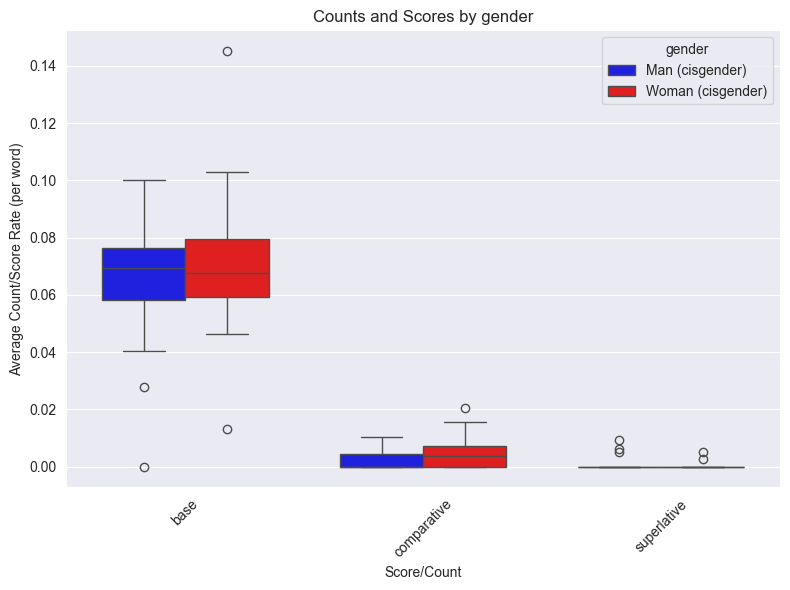

In [15]:
adj_types = ['base', 'comparative', 'superlative']
adj_lists = [base, comparative, superlative]
adj_cols = sum(adj_lists, [])

adj_counts = count(user_prompts, 'all_adjs', adj_types, adj_lists)

zero_cols = adj_counts.columns[(adj_counts.fillna(0.0) == 0.0).all()].tolist()
adj_cols = list(set(adj_cols) - set(zero_cols))
#box_plot(adj_counts, ['user_id', 'gender'], adj_cols, 'Adjective', 'Normalized Rate (100 Words)', 'gender', gender_palette)
box_plot(adj_counts, ['user_id', 'gender'], adj_types, 'Adjective', 'Normalized Rate (100 Words)', 'gender', gender_palette)

#box_plot(adj_counts, ['age'], adj_types, 'Adjective', 'Normalized Rate (100 Words)', 'age', age_palette)
#box_plot(adj_counts, ['age'], 'all_adjs', 'Adjective', 'Normalized Rate (100 Words)', 'age', age_palette)

In [16]:
adj_word_results = groupwise_comparison_with_correction(adj_counts, adj_cols)
adj_word_results = adj_word_results.sort_values(by="p_value", ascending=True)
adj_word_results

,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type,ci
5,more,Mann-Whitney U,greater,False,None,49.000000,0.012109,1.0,0.001838,0.0,0.004245,0.001159,13.0,15.0,8,3,-0.497436,RBC,"[-0.77, -0.15]"
148,new,Mann-Whitney U,greater,False,None,51.000000,0.025539,1.0,0.002227,0.0,0.010244,0.003255,13.0,15.0,10,5,-0.476923,RBC,"[-0.85, -0.14]"
219,same,Mann-Whitney U,greater,False,None,55.000000,0.035505,1.0,0.001779,0.0,0.008847,0.002934,13.0,15.0,9,4,-0.435897,RBC,"[-0.77, -0.07]"
185,different,Fisher's exact,greater,False,None,4.363636,0.211111,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1,4,4.363636,Odds ratio,None
63,insert,Fisher's exact,greater,False,None,4.363636,0.211111,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1,4,4.363636,Odds ratio,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,outlier,Fisher's exact,greater,False,None,0.000000,1.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0.000000,Odds ratio,None
94,responsible,Fisher's exact,greater,False,None,0.000000,1.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0.000000,Odds ratio,None
93,hard,Fisher's exact,greater,False,None,0.000000,1.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0.000000,Odds ratio,None
138,weird,Fisher's exact,greater,False,None,0.000000,1.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0.000000,Odds ratio,None


In [17]:
adj_group_results = groupwise_comparison_with_correction(adj_counts, adj_types)
adj_group_results = adj_group_results.sort_values(by="p_value", ascending=True)
adj_group_results

,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type,ci
1,comparative,Mann-Whitney U,greater,False,NaN,67.000000,0.133142,0.399426,0.003783,0.000000,0.006697,0.003553,13.0,15.0,8,5,-0.312821,RBC,"[-0.67, 0.11]"
0,base,T-test,two-sided,False,23.258648,-0.666278,0.511788,0.572222,0.070620,0.063493,0.030680,0.025110,13.0,15.0,13,14,-0.256206,Cohen's d,"[-0.96, 0.6]"
2,superlative,Fisher's exact,greater,False,NaN,1.375000,0.572222,0.572222,NaN,NaN,NaN,NaN,NaN,NaN,2,3,1.375000,Odds ratio,None


In [18]:
adj_all_results = groupwise_comparison_with_correction(adj_counts, ['all_adjs'])
adj_all_results = adj_all_results.sort_values(by="p_value", ascending=True)
adj_all_results

,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type,ci
0,all_adjs,T-test,two-sided,False,24.724913,-0.943577,0.354515,0.354515,0.077004,0.067109,0.028663,0.026483,13,15,13,14,-0.359651,Cohen's d,"[-1.0, 0.47]"


In [19]:
from helpers.make_latex_table import create_latex_tables
adj_combined = pd.concat([adj_all_results, adj_group_results], axis=0)
create_latex_tables(adj_combined, "latex/combined_adjs_stats", "latex/combined_adjs_hits")
adj_combined

,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type,ci
0,all_adjs,T-test,two-sided,False,24.724913,-0.943577,0.354515,0.354515,0.077004,0.067109,0.028663,0.026483,13.0,15.0,13,14,-0.359651,Cohen's d,"[-1.0, 0.47]"
1,comparative,Mann-Whitney U,greater,False,NaN,67.000000,0.133142,0.399426,0.003783,0.000000,0.006697,0.003553,13.0,15.0,8,5,-0.312821,RBC,"[-0.67, 0.11]"
0,base,T-test,two-sided,False,23.258648,-0.666278,0.511788,0.572222,0.070620,0.063493,0.030680,0.025110,13.0,15.0,13,14,-0.256206,Cohen's d,"[-0.96, 0.6]"
2,superlative,Fisher's exact,greater,False,NaN,1.375000,0.572222,0.572222,NaN,NaN,NaN,NaN,NaN,NaN,2,3,1.375000,Odds ratio,None


## Pragmatic Markers


/var/folders/w6/f5trsq6n2jx87f1mqgd_4vv80000gn/T/ipykernel_39060/3867638616.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[word_type] = df[word_list].sum(axis=1)
/var/folders/w6/f5trsq6n2jx87f1mqgd_4vv80000gn/T/ipykernel_39060/3867638616.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[word_type] = df[word_list].sum(axis=1)
/var/folders/w6/f5trsq6n2jx87f1mqgd_4vv80000gn/T/ipykernel_39060/3867638616.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

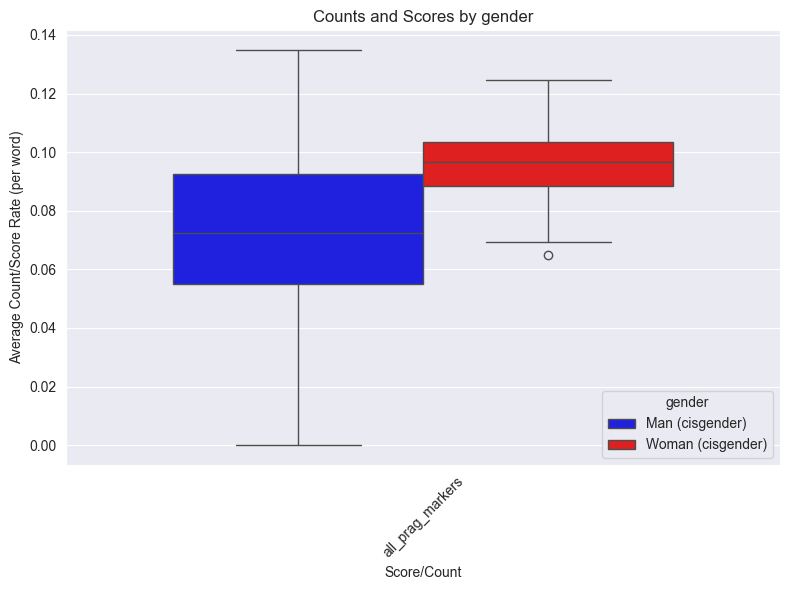

In [33]:
prag_marker_types = ['hedges', 'boosters', 'discourse_markers']
prag_marker_lists = [hedges, boosters, discourse_markers]
prag_marker_cols = sum(prag_marker_lists, [])

prag_marker_types_no_hedges = ['boosters', 'discourse_markers']
prag_marker_lists_no_hedges = [boosters, discourse_markers]
prag_marker_cols_no_hedges = sum(prag_marker_lists_no_hedges, [])

hedges_types = ['apologies', 'uncertainty_markers', 'uncertainty_expressions', 'modal_auxiliary_verbs']
hedges_lists = [apologies, uncertainty_markers, uncertainty_expressions, modal_auxiliary_verbs]

prag_marker_counts = count(user_prompts, 'all_prag_markers', prag_marker_types, prag_marker_lists)
hedges_counts = count(user_prompts, 'all_hedges', hedges_types, hedges_lists)

zero_cols = prag_marker_counts.columns[(prag_marker_counts.fillna(0.0) == 0.0).all()].tolist()
prag_marker_cols = list(set(prag_marker_cols) - set(zero_cols))
#box_plot(prag_marker_counts, ['user_id', 'gender'], prag_marker_cols, 'Marker', 'Normalized Rate (100 Words)', 'gender', gender_palette)
#box_plot(prag_marker_counts, ['user_id', 'gender'], prag_marker_types, 'Marker', 'Normalized Rate (100 Words)', 'gender', gender_palette)
box_plot(prag_marker_counts, ['user_id', 'gender'], ['all_prag_markers'], 'Marker', 'Normalized Rate (100 Words)', 'gender', gender_palette)


In [39]:
from helpers.make_latex_table import create_latex_tables

prag_word_results = groupwise_comparison_with_correction(prag_marker_counts, prag_marker_cols)
prag_word_results = prag_word_results.sort_values(by="p_value", ascending=True)
create_latex_tables(prag_word_results, "latex/prag_word_results_stats", "latex/prag_word_results_hits")
prag_word_results

,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type,ci
55,can,Mann-Whitney U,greater,False,None,56.0,0.056034,1.0,0.016014,0.004505,0.014670,0.010735,13.0,15.0,11,9,-0.425641,RBC,"[-0.75, -0.01]"
1,and,Mann-Whitney U,greater,False,None,65.0,0.140403,1.0,0.020305,0.016043,0.015239,0.010196,13.0,15.0,13,13,-0.333333,RBC,"[-0.7, 0.1]"
34,would,Mann-Whitney U,greater,False,None,69.0,0.161004,1.0,0.001779,0.000000,0.003014,0.004784,13.0,15.0,8,5,-0.292308,RBC,"[-0.65, 0.13]"
32,so,Mann-Whitney U,greater,False,None,69.0,0.174048,1.0,0.005960,0.000000,0.005266,0.003713,13.0,15.0,8,7,-0.292308,RBC,"[-0.72, 0.11]"
62,here,Mann-Whitney U,greater,False,None,73.0,0.182575,1.0,0.000000,0.000000,0.003378,0.007219,13.0,15.0,6,3,-0.251282,RBC,"[-0.62, 0.09]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18,previously,Fisher's exact,greater,False,None,0.0,1.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0.000000,Odds ratio,None
52,type of,Fisher's exact,greater,False,None,0.0,1.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0.000000,Odds ratio,None
30,suddenly,Fisher's exact,greater,False,None,0.0,1.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0.000000,Odds ratio,None
11,usually,Fisher's exact,greater,False,None,0.0,1.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0.000000,Odds ratio,None


In [40]:
prag_hedges_group_results = groupwise_comparison_with_correction(hedges_counts, hedges_types)
prag_hedges_group_results = prag_hedges_group_results.sort_values(by="p_value", ascending=True)
create_latex_tables(prag_hedges_group_results, "latex/hedges_stats", "latex/hedges_hits")
prag_hedges_group_results

,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type,ci
3,modal_auxiliary_verbs,T-test,two-sided,False,25.095434,-2.858460,0.008442,0.033770,0.030395,0.016874,0.012719,0.012204,13.0,15.0,13,12,-1.086484,Cohen's d,"[-1.99, -0.32]"
0,apologies,Fisher's exact,greater,False,NaN,inf,0.277778,0.555556,NaN,NaN,NaN,NaN,NaN,NaN,0,2,inf,Odds ratio,None
1,uncertainty_markers,Mann-Whitney U,greater,False,NaN,83.000000,0.483395,0.587923,0.001779,0.000000,0.005594,0.004574,13.0,15.0,7,6,-0.148718,RBC,"[-0.52, 0.25]"
2,uncertainty_expressions,Fisher's exact,greater,False,NaN,1.212121,0.587923,0.587923,NaN,NaN,NaN,NaN,NaN,NaN,3,4,1.212121,Odds ratio,None


In [41]:
prag_group_results = groupwise_comparison_with_correction(prag_marker_counts, prag_marker_types_no_hedges)
prag_group_results = prag_group_results.sort_values(by="p_value", ascending=True)
prag_group_results

,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type,ci
0,boosters,Mann-Whitney U,greater,False,NaN,72.000000,0.191298,0.355488,0.001568,0.000000,0.003113,0.002093,13,15,7,4,-0.261538,RBC,"[-0.63, 0.12]"
1,discourse_markers,T-test,two-sided,False,23.595982,-0.942499,0.355488,0.355488,0.057461,0.050508,0.014629,0.023866,13,15,13,14,-0.345332,Cohen's d,"[-1.1, 0.4]"


In [42]:
prag_overall_results = groupwise_comparison_with_correction(prag_marker_counts, ['all_prag_markers'])
prag_overall_results = prag_overall_results.sort_values(by="p_value", ascending=True)
prag_overall_results

,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type,ci
0,all_prag_markers,T-test,two-sided,False,21.568177,-2.117358,0.046006,0.046006,0.095374,0.072922,0.018556,0.035907,13,15,13,14,-0.768669,Cohen's d,"[-1.59, -0.04]"


In [43]:
only_hedges = groupwise_comparison_with_correction(prag_marker_counts, ['hedges'], one_sided=True, direction="smaller")
only_hedges = only_hedges.sort_values(by="p_value", ascending=True)
only_hedges

,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type,ci
0,hedges,T-test,smaller,True,25.856005,-2.368255,0.012817,0.012817,0.035585,0.021427,0.01404,0.017566,13,15,13,12,-0.882866,Cohen's d,"[-1.66, -0.01]"


In [44]:
prag_combined = pd.concat([prag_overall_results, only_hedges, prag_group_results], axis=0)
create_latex_tables(prag_combined, "latex/combined_prag_markers_stats", "latex/combined_prag_markers_hits")
prag_combined

,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type,ci
0,all_prag_markers,T-test,two-sided,False,21.568177,-2.117358,0.046006,0.046006,0.095374,0.072922,0.018556,0.035907,13,15,13,14,-0.768669,Cohen's d,"[-1.59, -0.04]"
0,hedges,T-test,smaller,True,25.856005,-2.368255,0.012817,0.012817,0.035585,0.021427,0.014040,0.017566,13,15,13,12,-0.882866,Cohen's d,"[-1.66, -0.01]"
0,boosters,Mann-Whitney U,greater,False,NaN,72.000000,0.191298,0.355488,0.001568,0.000000,0.003113,0.002093,13,15,7,4,-0.261538,RBC,"[-0.63, 0.12]"
1,discourse_markers,T-test,two-sided,False,23.595982,-0.942499,0.355488,0.355488,0.057461,0.050508,0.014629,0.023866,13,15,13,14,-0.345332,Cohen's d,"[-1.1, 0.4]"


## Interactions


/var/folders/w6/f5trsq6n2jx87f1mqgd_4vv80000gn/T/ipykernel_39060/3867638616.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[word] = df['conversational'].apply(lambda x: (count_occurrences(x, word, True))/len(x.split()))
/var/folders/w6/f5trsq6n2jx87f1mqgd_4vv80000gn/T/ipykernel_39060/3867638616.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[word] = df['conversational'].apply(lambda x: (count_occurrences(x, word, True))/len(x.split()))
/var/folders/w6/f5trsq6n2jx87f1mqgd_4vv80000gn/T/ipykernel_39060/3867638616.py

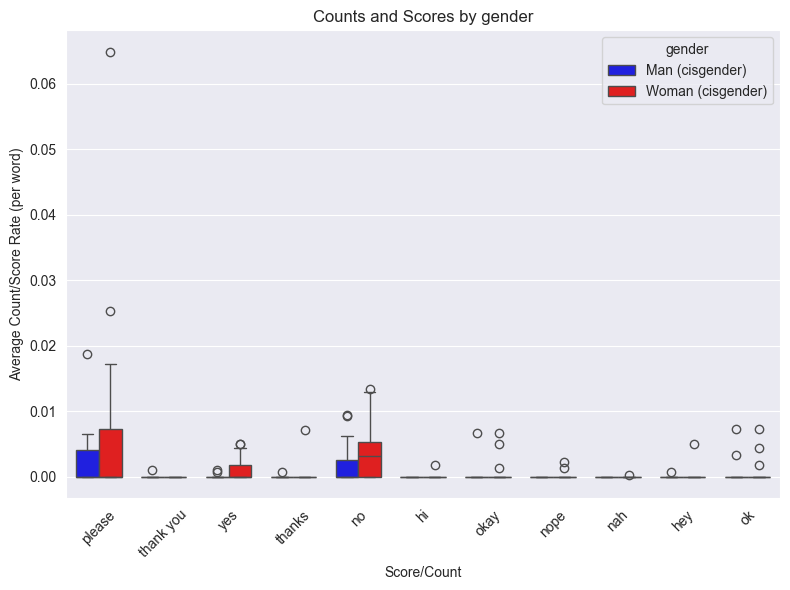

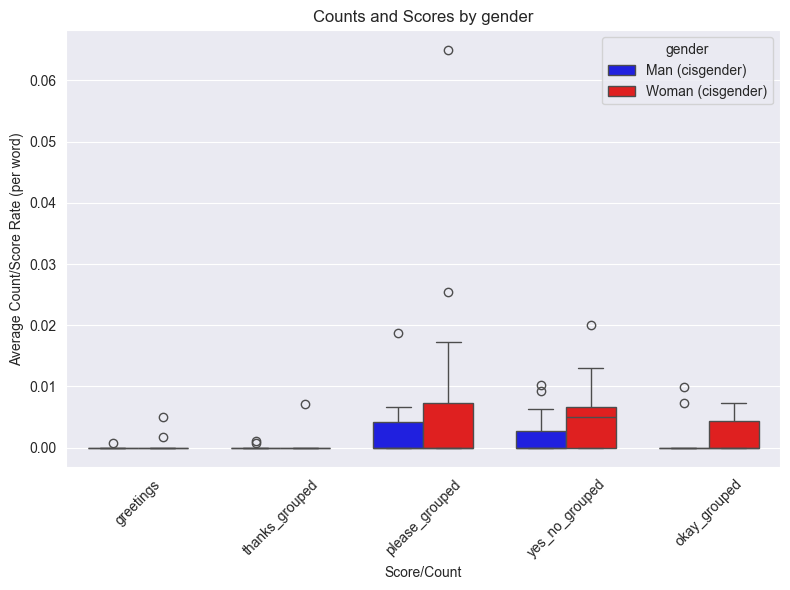

,user_id,gender,age,work_exp_years,conversational,n_words,I,me,my,mine,...,please_grouped,yes,no,nah,nope,yes_no_grouped,okay,ok,okay_grouped,all_int_markers
0,6,Man (cisgender),19-25,3.0,"parsing data from python iterator, how it coul...",196,0.015306,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,8,Man (cisgender),19-25,1.0,\n i am working on the problem of reconstru...,36,0.027778,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,11,Woman (cisgender),26-30,1.0,can you adapt the following code so that inste...,194,0.030928,0.005155,0.015464,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,15,Man (cisgender),26-30,6.0,set_all_tables action is currently not fetchin...,36,0.055556,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,16,Woman (cisgender),19-25,None,i want to use dummy hot encoding to replace th...,544,0.051471,0.001838,0.005515,0.0,...,0.007353,0.001838,0.003676,0.000000,0.000000,0.005515,0.000000,0.007353,0.007353,0.020221
5,25,Man (cisgender),26-30,6.0,what is the best way to encode and compress a ...,108,0.027778,0.000000,0.000000,0.0,...,0.000000,0.000000,0.009259,0.000000,0.000000,0.009259,0.000000,0.000000,0.000000,0.009259
6,28,Woman (cisgender),31-35,5.0,i have a pandas dataframe like this:\n\ni want...,562,0.039146,0.010676,0.005338,0.0,...,0.007117,0.000000,0.005338,0.000000,0.000000,0.005338,0.000000,0.001779,0.001779,0.023132
7,29,Woman (cisgender),26-30,None,now i want to bring judgement balancing into t...,62,0.032258,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,31,Man (cisgender),36-40,22.0,how can i make use of an observablehqdatabasec...,92,0.032609,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,34,Man (cisgender),51-60,20.0,blender and python. i have a collection of hun...,1309,0.019862,0.000000,0.001528,0.0,...,0.003820,0.000000,0.003056,0.000000,0.000000,0.003056,0.000000,0.000000,0.000000,0.006875


In [45]:
int_marker_types = ['greetings', 'thanks_grouped', 'please_grouped', 'yes_no_grouped', 'okay_grouped']
int_marker_lists = [greetings, thanks_grouped, please_grouped, yes_no_grouped, okay_grouped]
int_marker_cols = sum(int_marker_lists, [])

int_marker_counts = count(user_prompts, 'all_int_markers', int_marker_types, int_marker_lists)

zero_cols = int_marker_counts.columns[(int_marker_counts.fillna(0.0) == 0.0).all()].tolist()
int_marker_cols = list(set(int_marker_cols) - set(zero_cols))
box_plot(int_marker_counts, ['user_id', 'gender'], int_marker_cols, 'Marker', 'Normalized Rate (100 Words)', 'gender', gender_palette)
box_plot(int_marker_counts, ['user_id', 'gender'], int_marker_types, 'Marker', 'Normalized Rate (100 Words)', 'gender', gender_palette)

int_marker_counts

In [46]:
int_word_results = groupwise_comparison_with_correction(int_marker_counts, int_marker_cols)
int_word_results = int_word_results.sort_values(by="p_value", ascending=True)
int_word_results

,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type,ci
4,no,Mann-Whitney U,greater,False,None,77.000000,0.316722,1.0,0.003137,0.0,0.004777,0.003430,13.0,15.0,7,6,-0.210256,RBC,"[-0.6, 0.18]"
0,please,Mann-Whitney U,greater,False,None,78.000000,0.320647,1.0,0.000000,0.0,0.018440,0.005091,13.0,15.0,6,5,-0.200000,RBC,"[-0.59, 0.18]"
1,thank you,Fisher's exact,greater,False,None,inf,0.535714,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0,1,inf,Odds ratio,None
3,thanks,Fisher's exact,greater,False,None,0.857143,0.793651,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1,1,0.857143,Odds ratio,None
9,hey,Fisher's exact,greater,False,None,0.857143,0.793651,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1,1,0.857143,Odds ratio,None
10,ok,Fisher's exact,greater,False,None,0.512821,0.877778,1.0,NaN,NaN,NaN,NaN,NaN,NaN,3,2,0.512821,Odds ratio,None
6,okay,Fisher's exact,greater,False,None,0.238095,0.965079,1.0,NaN,NaN,NaN,NaN,NaN,NaN,3,1,0.238095,Odds ratio,None
2,yes,Fisher's exact,greater,False,None,0.246154,0.976812,1.0,NaN,NaN,NaN,NaN,NaN,NaN,5,2,0.246154,Odds ratio,None
5,hi,Fisher's exact,greater,False,None,0.000000,1.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0.000000,Odds ratio,None
7,nope,Fisher's exact,greater,False,None,0.000000,1.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2,0,0.000000,Odds ratio,None


In [47]:
from helpers.make_latex_table import create_latex_tables
int_group_results = groupwise_comparison_with_correction(int_marker_counts, int_marker_types)
int_group_results = int_group_results.sort_values(by="p_value", ascending=True)
create_latex_tables(int_group_results, "interactions_stats", "interactions_hits")
int_group_results

,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type,ci
4,okay_grouped,Mann-Whitney U,greater,False,None,70.500000,0.125847,0.333008,0.000000,0.0,0.002802,0.003075,13.0,15.0,6,2,-0.276923,RBC,"[-0.62, 0.08]"
3,yes_no_grouped,Mann-Whitney U,greater,False,None,66.500000,0.133203,0.333008,0.005076,0.0,0.006175,0.003534,13.0,15.0,8,6,-0.317949,RBC,"[-0.66, 0.11]"
2,please_grouped,Mann-Whitney U,greater,False,None,78.000000,0.320647,0.534411,0.000000,0.0,0.018440,0.005091,13.0,15.0,6,5,-0.200000,RBC,"[-0.57, 0.21]"
1,thanks_grouped,Fisher's exact,greater,False,None,1.846154,0.555556,0.694444,NaN,NaN,NaN,NaN,NaN,NaN,1,2,1.846154,Odds ratio,None
0,greetings,Fisher's exact,greater,False,None,0.392857,0.912698,0.912698,NaN,NaN,NaN,NaN,NaN,NaN,2,1,0.392857,Odds ratio,None


In [48]:
int_overall_results = groupwise_comparison_with_correction(int_marker_counts, ['all_int_markers'])
int_overall_results = int_overall_results.sort_values(by="p_value", ascending=True)
int_overall_results

,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type,ci
0,all_int_markers,Mann-Whitney U,greater,False,None,65.5,0.120944,0.120944,0.011349,0.0,0.022495,0.009336,13,15,8,6,-0.328205,RBC,"[-0.7, 0.1]"


In [49]:
int_combined = pd.concat([int_overall_results, int_group_results], axis=0)
create_latex_tables(int_combined, "latex/interactions_combined_stats", "latex/interactions_combined_hits")
int_combined

,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type,ci
0,all_int_markers,Mann-Whitney U,greater,False,None,65.500000,0.120944,0.120944,0.011349,0.0,0.022495,0.009336,13.0,15.0,8,6,-0.328205,RBC,"[-0.7, 0.1]"
4,okay_grouped,Mann-Whitney U,greater,False,None,70.500000,0.125847,0.333008,0.000000,0.0,0.002802,0.003075,13.0,15.0,6,2,-0.276923,RBC,"[-0.62, 0.08]"
3,yes_no_grouped,Mann-Whitney U,greater,False,None,66.500000,0.133203,0.333008,0.005076,0.0,0.006175,0.003534,13.0,15.0,8,6,-0.317949,RBC,"[-0.66, 0.11]"
2,please_grouped,Mann-Whitney U,greater,False,None,78.000000,0.320647,0.534411,0.000000,0.0,0.018440,0.005091,13.0,15.0,6,5,-0.200000,RBC,"[-0.57, 0.21]"
1,thanks_grouped,Fisher's exact,greater,False,None,1.846154,0.555556,0.694444,NaN,NaN,NaN,NaN,NaN,NaN,1,2,1.846154,Odds ratio,None
0,greetings,Fisher's exact,greater,False,None,0.392857,0.912698,0.912698,NaN,NaN,NaN,NaN,NaN,NaN,2,1,0.392857,Odds ratio,None


## Informal

/var/folders/w6/f5trsq6n2jx87f1mqgd_4vv80000gn/T/ipykernel_39060/3867638616.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[word] = df['conversational'].apply(lambda x: (count_occurrences(x, word, True))/len(x.split()))
/var/folders/w6/f5trsq6n2jx87f1mqgd_4vv80000gn/T/ipykernel_39060/3867638616.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[word] = df['conversational'].apply(lambda x: (count_occurrences(x, word, True))/len(x.split()))
/var/folders/w6/f5trsq6n2jx87f1mqgd_4vv80000gn/T/ipykernel_39060/3867638616.py

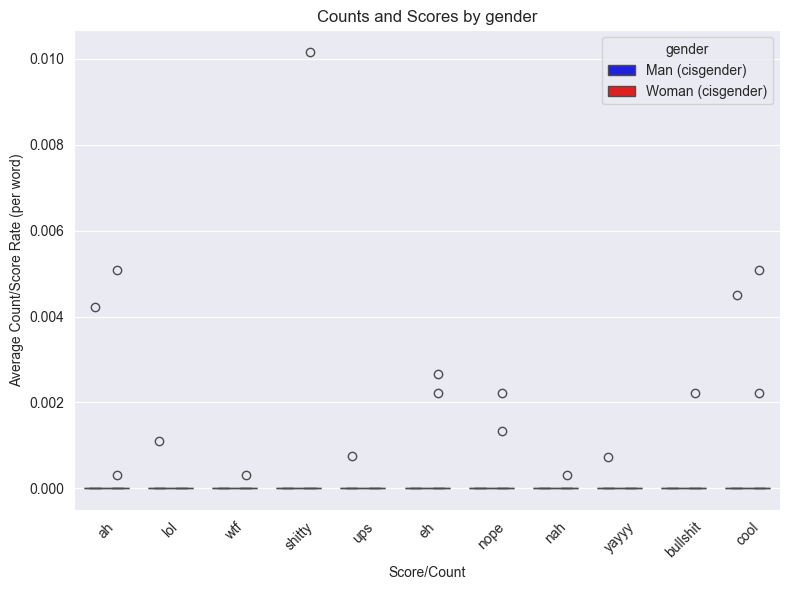

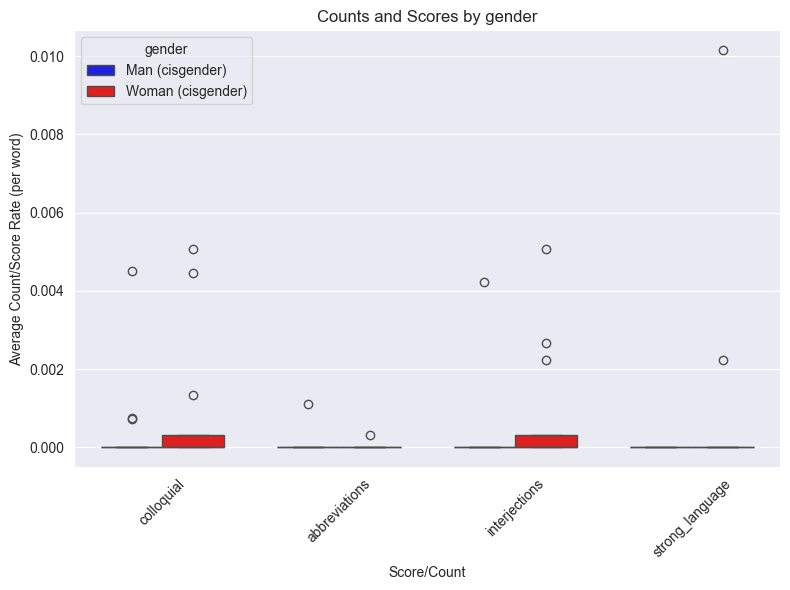

In [50]:
inf_marker_types = ['colloquial', 'abbreviations', 'interjections', 'strong_language']
inf_marker_lists = [colloquial, abbreviations, interjections, strong_language]
inf_marker_cols = sum(inf_marker_lists, [])

inf_marker_counts = count(user_prompts, 'all_inf_markers', inf_marker_types, inf_marker_lists)

zero_cols = inf_marker_counts.columns[(inf_marker_counts.fillna(0.0) == 0.0).all()].tolist()
inf_marker_cols = list(set(inf_marker_cols) - set(zero_cols))
box_plot(inf_marker_counts, ['user_id', 'gender'], inf_marker_cols, 'Marker', 'Normalized Rate (100 Words)', 'gender', gender_palette)
box_plot(inf_marker_counts, ['user_id', 'gender'], inf_marker_types, 'Marker', 'Normalized Rate (100 Words)', 'gender', gender_palette)

In [51]:
inf_word_results = groupwise_comparison_with_correction(inf_marker_counts, inf_marker_cols)
inf_word_results = inf_word_results.sort_values(by="p_value", ascending=True)
inf_word_results

,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type,ci
1,lol,Fisher's exact,greater,False,None,inf,0.535714,1.0,None,None,None,None,None,None,0,1,inf,Odds ratio,None
4,ups,Fisher's exact,greater,False,None,inf,0.535714,1.0,None,None,None,None,None,None,0,1,inf,Odds ratio,None
8,yayyy,Fisher's exact,greater,False,None,inf,0.535714,1.0,None,None,None,None,None,None,0,1,inf,Odds ratio,None
0,ah,Fisher's exact,greater,False,None,0.392857,0.912698,1.0,None,None,None,None,None,None,2,1,0.392857,Odds ratio,None
10,cool,Fisher's exact,greater,False,None,0.392857,0.912698,1.0,None,None,None,None,None,None,2,1,0.392857,Odds ratio,None
2,wtf,Fisher's exact,greater,False,None,0.000000,1.000000,1.0,None,None,None,None,None,None,1,0,0.000000,Odds ratio,None
3,shitty,Fisher's exact,greater,False,None,0.000000,1.000000,1.0,None,None,None,None,None,None,1,0,0.000000,Odds ratio,None
5,eh,Fisher's exact,greater,False,None,0.000000,1.000000,1.0,None,None,None,None,None,None,2,0,0.000000,Odds ratio,None
6,nope,Fisher's exact,greater,False,None,0.000000,1.000000,1.0,None,None,None,None,None,None,2,0,0.000000,Odds ratio,None
7,nah,Fisher's exact,greater,False,None,0.000000,1.000000,1.0,None,None,None,None,None,None,1,0,0.000000,Odds ratio,None


In [52]:
inf_group_results  = groupwise_comparison_with_correction(inf_marker_counts, inf_marker_types)
inf_group_results  = inf_group_results .sort_values(by="p_value", ascending=True)
inf_group_results

,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type,ci
1,abbreviations,Fisher's exact,greater,False,None,0.857143,0.793651,1.0,None,None,None,None,None,None,1,1,0.857143,Odds ratio,None
0,colloquial,Fisher's exact,greater,False,None,0.562500,0.862681,1.0,None,None,None,None,None,None,4,3,0.562500,Odds ratio,None
2,interjections,Fisher's exact,greater,False,None,0.160714,0.986905,1.0,None,None,None,None,None,None,4,1,0.160714,Odds ratio,None
3,strong_language,Fisher's exact,greater,False,None,0.000000,1.000000,1.0,None,None,None,None,None,None,2,0,0.000000,Odds ratio,None


In [53]:
inf_overall_result = groupwise_comparison_with_correction(inf_marker_counts, ['all_inf_markers'])
inf_overall_result = inf_overall_result.sort_values(by="p_value", ascending=True)
inf_overall_result

,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type,ci
0,all_inf_markers,Fisher's exact,greater,False,None,1.125,0.603623,0.603623,None,None,None,None,None,None,4,5,1.125,Odds ratio,None


In [54]:
inf_combined = pd.concat([inf_overall_result, inf_group_results], axis=0)
create_latex_tables(inf_combined, "latex/informal_stats", "latex/informal_hits")
inf_combined

,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type,ci
0,all_inf_markers,Fisher's exact,greater,False,None,1.125000,0.603623,0.603623,None,None,None,None,None,None,4,5,1.125000,Odds ratio,None
1,abbreviations,Fisher's exact,greater,False,None,0.857143,0.793651,1.000000,None,None,None,None,None,None,1,1,0.857143,Odds ratio,None
0,colloquial,Fisher's exact,greater,False,None,0.562500,0.862681,1.000000,None,None,None,None,None,None,4,3,0.562500,Odds ratio,None
2,interjections,Fisher's exact,greater,False,None,0.160714,0.986905,1.000000,None,None,None,None,None,None,4,1,0.160714,Odds ratio,None
3,strong_language,Fisher's exact,greater,False,None,0.000000,1.000000,1.000000,None,None,None,None,None,None,2,0,0.000000,Odds ratio,None
